## Importing Dependencies

In [2]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix


## Load the data

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts a PIL Image or numpy.ndarray to tensor.
    transforms.Normalize((0.5,), (0.5,))  # Normalizes a tensor image with mean and standard deviation.
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=1024, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5485960.90it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 161477.23it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1306020.67it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9167723.18it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [4]:
len(trainset)

60000

In [5]:
print(len(trainloader))

59


In [6]:
len(trainset) / 1024

58.59375

In [7]:
trainset[1001][1]

7

## Data Visualization

In [8]:
def imshow(image, ax = None, title = None, normalize = True):

  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1,2,0))

  if normalize:
    mean = np.array((.5,))
    std = np.array((.5,))
    image = std* image + mean
    image = np.clip(image, 0, 1)

  ax.imshow(image.squeeze(), cmap = 'gray')
  if title:
    ax.set_title(title)
  ax.axis('off')

  return ax

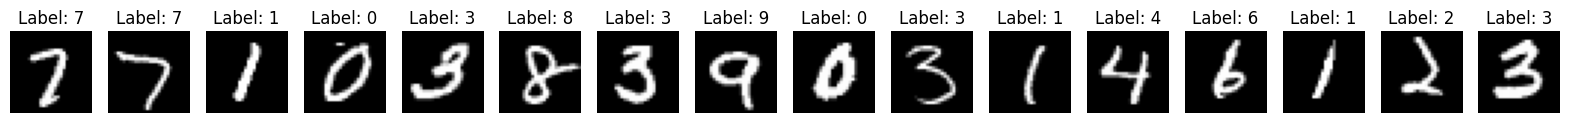

In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(figsize=(20, 4), ncols=16)
for ii in range(16):
    ax = axes[ii]
    imshow(images[ii], ax=ax, title=f"Label: {labels[ii]}")


## Analyze the Dataset

In [10]:
print("Length of the train dataset: ", len(trainset))
print("Length of the test dataset: ", len(testset))
print("Length of the dataset: ", len(trainset))
print("Image shape: ", trainset[0][0].shape)
print('--'*40)

from collections import Counter
train_labels = [label for _, label in trainset]
label_count  = Counter(train_labels)
print('Training Set Class Distribution:', label_count)

Length of the train dataset:  60000
Length of the test dataset:  10000
Length of the dataset:  60000
Image shape:  torch.Size([1, 28, 28])
--------------------------------------------------------------------------------
Training Set Class Distribution: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


## Define the Model

In [11]:
# Define the neural network class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Dropout layers to reduce overfitting
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        # Fully connected layers with dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output



## Hyperparameter and Early Stopping

In [17]:
# Hyperparameters
learning_rate = 0.001
batch_size = 1024
n_epochs = 50
patience = 5

# Initialize the network and optimizer
model = Net()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [18]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Devive = ", device)
model.to(device)

val_loss_min = np.Inf
patience_counter = 0

Devive =  cuda


In [19]:
torch.cuda.is_available()

True

## Train-Validation-Test Split

In [20]:
num_train = len(trainset)
num_valid = int(0.2 * num_train)
num_train = num_train -  num_valid

train_data, valid_data  = random_split(trainset, [num_train,num_valid])

## Data Loader

In [21]:
train_loader = DataLoader(train_data, batch_size = 1024, shuffle  = True)
valid_loader = DataLoader(valid_data, batch_size = 1024, shuffle  = True)

## Train-Validation-Test Loop

In [22]:
for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  correct = 0
  total = 0

  model.train()

  for idx, (data,target) in enumerate(tqdm(train_loader)):
    data, target = data.to(device),target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    train_loss = train_loss + loss.item() * data.size(0)


  model.eval()

  for idx, (data, target) in enumerate(tqdm(valid_loader)):
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    valid_loss = valid_loss + loss.item()*data.size(0)
    pred = output.argmax(dim = 1, keepdim = True)
    correct = correct + pred.eq(target.view_as(pred)).sum().item()
    total  = total + target.size(0)


  train_loss = train_loss / len(train_loader.sampler)
  valid_loss = valid_loss / len(valid_loader.sampler)
  accuracy = (correct / total) * 100


  print('Epoch: {} \ Training Loss {:.6f} \tValidation Loss: {:.6f} \Accuracy: {:.2f}%'.format(epoch, train_loss, valid_loss, accuracy))

  if valid_loss <= val_loss_min:
    print('Validation loss decreases ({:.6f} --> {:.6f}). saving model....'.format(val_loss_min,valid_loss,))
    torch.save(model.state_dict(), 'model_cifar.pt')
    val_loss_min = valid_loss
    patiences_counter = 0

  else:
    patience_counter+=1
    print(f'EarlyStopping counter: {patience_counter} out of {patience}')

    if patience_counter >= patience:
      print('Early Stopping Triggered')
      break

100%|██████████| 12/12 [00:02<00:00,  4.23it/s]


Epoch: 1 \ Training Loss 0.734116 	Validation Loss: 0.199722 \Accuracy: 94.21%
Validation loss decreases (inf --> 0.199722). saving model....


100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


Epoch: 2 \ Training Loss 0.206723 	Validation Loss: 0.099683 \Accuracy: 97.19%
Validation loss decreases (0.199722 --> 0.099683). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch: 3 \ Training Loss 0.129224 	Validation Loss: 0.073080 \Accuracy: 97.84%
Validation loss decreases (0.099683 --> 0.073080). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Epoch: 4 \ Training Loss 0.096260 	Validation Loss: 0.059340 \Accuracy: 98.21%
Validation loss decreases (0.073080 --> 0.059340). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


Epoch: 5 \ Training Loss 0.080487 	Validation Loss: 0.057024 \Accuracy: 98.21%
Validation loss decreases (0.059340 --> 0.057024). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


Epoch: 6 \ Training Loss 0.069037 	Validation Loss: 0.053887 \Accuracy: 98.34%
Validation loss decreases (0.057024 --> 0.053887). saving model....


100%|██████████| 12/12 [00:03<00:00,  3.70it/s]


Epoch: 7 \ Training Loss 0.063205 	Validation Loss: 0.049884 \Accuracy: 98.56%
Validation loss decreases (0.053887 --> 0.049884). saving model....


100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


Epoch: 8 \ Training Loss 0.058325 	Validation Loss: 0.047233 \Accuracy: 98.60%
Validation loss decreases (0.049884 --> 0.047233). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.29it/s]


Epoch: 9 \ Training Loss 0.053623 	Validation Loss: 0.046265 \Accuracy: 98.68%
Validation loss decreases (0.047233 --> 0.046265). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch: 10 \ Training Loss 0.047078 	Validation Loss: 0.044956 \Accuracy: 98.76%
Validation loss decreases (0.046265 --> 0.044956). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.74it/s]


Epoch: 11 \ Training Loss 0.043878 	Validation Loss: 0.041017 \Accuracy: 98.90%
Validation loss decreases (0.044956 --> 0.041017). saving model....


100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch: 12 \ Training Loss 0.042667 	Validation Loss: 0.043069 \Accuracy: 98.85%
EarlyStopping counter: 1 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.80it/s]


Epoch: 13 \ Training Loss 0.035561 	Validation Loss: 0.046539 \Accuracy: 98.84%
EarlyStopping counter: 2 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch: 14 \ Training Loss 0.034175 	Validation Loss: 0.045792 \Accuracy: 98.88%
EarlyStopping counter: 3 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Epoch: 15 \ Training Loss 0.032943 	Validation Loss: 0.042699 \Accuracy: 98.97%
EarlyStopping counter: 4 out of 5


100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

Epoch: 16 \ Training Loss 0.030938 	Validation Loss: 0.045399 \Accuracy: 98.82%
EarlyStopping counter: 5 out of 5
Early Stopping Triggered


## Load the best Model and Evaluate

In [23]:
# Load the best model
model.load_state_dict(torch.load('model_cifar.pt'))

# Test the model using the testset
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Evaluating the model we saved usign the testset
model.eval()
with torch.no_grad():
  for idx, (data,target) in enumerate(tqdm(testloader)):
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output,target)
    test_loss = test_loss + loss.item()*data.size(0)

    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.view_as(pred))

    if not torch.cuda.is_available():
      correct = np.squeeze(correct_tensor.numpy())
    else:
      correct = np.squeeze(correct_tensor.cpu().numpy())

    for i in range(len(target)):
      label = target[i]
      class_correct[label] = class_correct[label] + correct[i].item()
      class_total[label]+=1



100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


In [24]:
classes = [str(i) for i in range(10)]  # Creates a list of class names ['0', '1', ..., '9']

# Calculate and print avg test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.032940

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 98% (1020/1032)
Test Accuracy of     3: 99% (1000/1010)
Test Accuracy of     4: 98% (971/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 98% (993/1009)

Test Accuracy (Overall): 98% (9894/10000)


In [25]:
# Print classification report and confusion matrix
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)
        y_true.extend(target.view_as(preds).tolist())
        y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1128    1    1    0    1    4    0    0    0]
 [   1    2 1020    1    2    0    0    4    2    0]
 [   0    0    2 1000    0    4    0    2    1    1]
 [   0    0    0    0  971   